#### Collecting the needed data
We will get the list of London boroughs and neighborhoods from Wikipedia. <br>
First, we will download the needed packages and import the libraries. 

In [1]:
!conda install -c conda-forge --no-deps wikipedia --yes   # installing Wikipedia package 

# installing BeautifulSoup and lxml packages
!conda install -c conda-forge --no-deps beautifulsoup4 --yes   
!conda install -c conda-forge --no-deps lxml --yes  

# installing Geocoder and related packages
!conda install -c conda-forge --no-deps geocoder --yes    
!conda install -c conda-forge --no-deps ratelim --yes   
!conda install -c conda-forge --no-deps click --yes   
!conda install -c conda-forge --no-deps altair --yes    
!conda install -c conda-forge --no-deps vincent --yes   

!conda install -c conda-forge geopy=1.21.0 --yes   # installing Geopy package 

!conda install -c conda-forge --no-deps folium=0.10.1 --yes   # installing Folium package 

!conda install -c conda-forge --no-deps googlemaps --yes   # installing googlemaps package

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - wikipedia


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wikipedia-1.4.0            |             py_2          13 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          13 KB

The following NEW packages will be INSTALLED:

  wikipedia          conda-forge/noarch::wikipedia-1.4.0-py_2



wikipedia-1.4.0      | 13 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::wikipedia==1.4.0=py_2
done

## Package Plan 

<br>Get data from Wikipedia

In [2]:
import requests
import pandas as pd
import random  # library for random number generation

from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from urllib.request import urlopen

url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
parsed_table = []

def get_wikipedia_data(u):
    wiki_url = requests.get(u).text
    soup = BeautifulSoup(wiki_url, 'html5lib')
    rows = soup.find('table', class_='wikitable sortable').find_all('tr')
    
    for row in rows:
        children = row.findChildren(recursive=False)
        row_text = []
        for child in children:
            clean_text = child.text
            clean_text = clean_text.split('&#91;')[0]     # This is to discard reference/citation links
            clean_text = clean_text.split('&#160;')[-1]   # This is to clean the header row of the sort icons
            clean_text = clean_text.strip()
            row_text.append(clean_text)
            parsed_table.append(row_text)
   
    return parsed_table

if __name__=="__main__":
    print ('this is the data:')
    tor_list = get_wikipedia_data(url) 
    #for row in tor_df:
    #    print ('|'.join(row))

# Create our dataframe from the html text
london_neighborhood_df = pd.DataFrame (tor_list,columns=['Location', 'London borough', 'Post town', 'Postcode district', 'Dial code', 'OS grid ref'])

# To eliminate all duplicate rows
london_neighborhood_df = london_neighborhood_df.drop_duplicates()

# To drop first row in the dataframe, since it's listing the columns' names
london_neighborhood_df.drop(london_neighborhood_df.index[:1], inplace=True)

london_neighborhood_df.head(10)

this is the data:


,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
6,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
12,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
18,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
24,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
30,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728
36,Aldborough Hatch,Redbridge[9],ILFORD,IG2,020,TQ455895
42,Aldgate,City[10],LONDON,EC3,020,TQ334813
48,Aldwych,Westminster[10],LONDON,WC2,020,TQ307810
54,Alperton,Brent[11],WEMBLEY,HA0,020,TQ185835
60,Anerley,Bromley[11],LONDON,SE20,020,TQ345695


In [3]:
# Cleaning our data

# Create a new dataframe with only the needed columns
london_df = london_neighborhood_df[['Location', 'London borough']].copy()

# Rename the columns
london_df.rename(columns = {'Location':'Neighborhood', 'London borough':'Borough'}, inplace = True) 

# Remove rows with a neighborhood that is "Not assigned".
london_df.drop(london_df[london_df['Neighborhood']=="Not assigned"].index,axis=0, inplace=True)

# If a Neighborhood is listed more than once, regroup all the boroughs in one row and seperate them with ','
london_df = london_df.groupby("Neighborhood").agg(lambda x:','.join(set(x)))

# If a neighborhood has more than one borough, only keep the first borough
london_df['Borough'] = london_df['Borough'].str.split(',').str[0]

# Some Boroughs have a number in the end (related to Wikipedia page), so we removed this
london_df['Borough'] = london_df['Borough'].str.split('[').str[0]

# We are replacing the borough "city" by "city of London"
london_df['Borough'] = london_df['Borough'].str.replace('City','City of London')

london_df.reset_index(level=0, inplace=True)

print(london_df.shape)
london_df.head(10)

(527, 2)


,Neighborhood,Borough
0,Abbey Wood,Bexley
1,Acton,Ealing
2,Addington,Croydon
3,Addiscombe,Croydon
4,Albany Park,Bexley
5,Aldborough Hatch,Redbridge
6,Aldgate,City of London
7,Aldwych,Westminster
8,Alperton,Brent
9,Anerley,Bromley


In [4]:
# Let's check how many neighborhoods and boroughs we have

print('There are {} uniques Neighborhoods.'.format(len(london_df['Neighborhood'].unique())))
print('There are {} uniques Boroughs.'.format(len(london_df['Borough'].unique())))

There are 527 uniques Neighborhoods.
There are 38 uniques Boroughs.


<br> We will now use the package Geopy to get the latitude and longitude coordinates for each neighborhood. <br>
The challenge was that this package was not always reliable, and in our case, the request returned a "service not available" error if we exceeded 45 requests in one time. As a workaround, we split the request per sections, each one covering 44 requests.

In [5]:
from geopy.geocoders import Nominatim

london_df['Latitude'] = ""
london_df['Longitude'] = ""
geolocator = Nominatim(user_agent="capstone_project")

for index, row in london_df.iterrows():
    if index<44:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        try:
            latitude = location.latitude
            longitude = location.longitude
        except:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [6]:
for index, row in london_df.iterrows():
    if index>=44 and index<88:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        try:
            latitude = location.latitude
            longitude = location.longitude
        except:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [7]:
for index, row in london_df.iterrows():
    if index>=88 and index<132:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [8]:
for index, row in london_df.iterrows():
    if index>=132 and index<176:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [9]:
for index, row in london_df.iterrows():
    if index>=176 and index<220:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [10]:
for index, row in london_df.iterrows():
    if index>=220 and index<263:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [11]:
for index, row in london_df.iterrows():
    if index>=263 and index<307:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [12]:
for index, row in london_df.iterrows():
    if index>=307 and index<350:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [13]:
for index, row in london_df.iterrows():
    if index>=350 and index<394:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [14]:
for index, row in london_df.iterrows():
    if index>=394 and index<438:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [15]:
for index, row in london_df.iterrows():
    if index>=438 and index<482:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [16]:
for index, row in london_df.iterrows():
    if index>=482:
        site = row['Neighborhood']+", London, UK"
        location = geolocator.geocode(site)
        if location:
            try:
                latitude = location.latitude
                longitude = location.longitude
            except:
                latitude = 'N/A'
                longitude = 'N/A'
        else:
            latitude = 'N/A'
            longitude = 'N/A'
        row['Latitude'] = latitude
        row['Longitude'] = longitude

In [17]:
# Remove rows with a latitude or longitude that is "N/A" or empty.
london_df.drop(london_df[london_df['Latitude']=="N/A"].index,axis=0, inplace=True)
london_df.drop(london_df[london_df['Latitude']==""].index,axis=0, inplace=True)
london_df.drop(london_df[london_df['Longitude']=="N/A"].index,axis=0, inplace=True)
london_df.drop(london_df[london_df['Longitude']==""].index,axis=0, inplace=True)

print(london_df.shape)
london_df.tail(20)

(517, 4)


,Neighborhood,Borough,Latitude,Longitude
506,Westcombe Park,Greenwich,51.4842,0.0188787
507,Westminster,Westminster,51.5014,-0.12493
508,Whetstone,Barnet,51.6302,-0.174884
509,White City,Hammersmith and Fulham,51.5119,-0.224236
510,Whitechapel,Tower Hamlets,51.5186,-0.0620807
511,Whitton,Richmond upon Thames,51.4512,-0.357976
513,Willesden,Brent,51.5466,-0.235866
514,Wimbledon,Merton,51.4215,-0.206403
515,Winchmore Hill,Enfield,51.6334,-0.103362
516,Wood Green,Haringey,51.596,-0.109147


In [6]:
# Save the information so far to a .csv file 
#london_df.to_csv('london_df.csv')
london_df = pd.read_csv('london_df.csv')

<br> It will be useful for our analysis later to know the population by borough. This information is available in another dataset that we got from (https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough page (https://en.wikipedia.org/wiki/List_of_London_boroughs), but it's specific by borough, not by neighborhood. <br>
We will create new DataFrame 'London_population_df' that we will need later on in this project.

In [7]:
import csv

!wget -q -O 'population_borough_london.csv' https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/77e9257d-ad9d-47aa-aeed-59a00741f301/housing-density-borough.csv
lp_df = pd.read_csv('population_borough_london.csv')

# Select the year 2019
lp_df = lp_df[lp_df.Year == 2019]

# Create a new dataframe with only the needed columns
london_population_df = lp_df[['Name', 'Population']].copy()

# Rename the columns
london_population_df.rename(columns = {'Name':'Borough'}, inplace = True) 

print(london_population_df.shape)
london_population_df.head(10)

(36, 2)


,Borough,Population
20,City of London,7953
72,Barking and Dagenham,214858
124,Barnet,402363
176,Bexley,252885
228,Brent,340710
280,Bromley,334292
332,Camden,255526
384,Croydon,396548
436,Ealing,354184
488,Enfield,339480


<br>Now that got the needed data, let's analyze it. <br>We start by checking how many neighborhouds are per borough: <br>

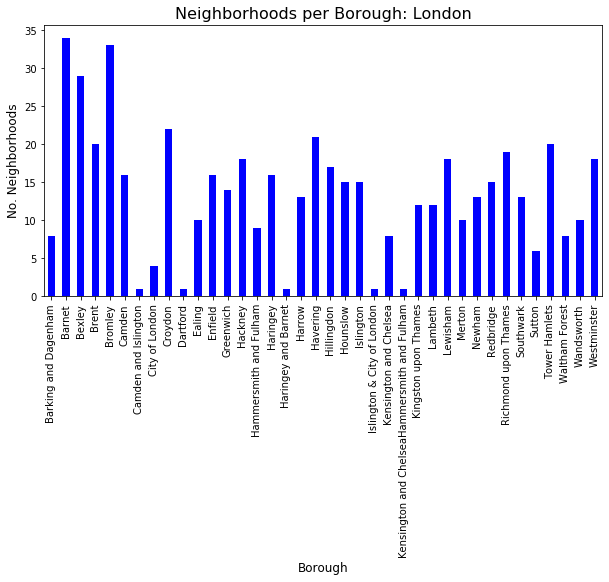

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

london_df.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color="blue")
plt.title('Neighborhoods per Borough: London', fontsize = 16)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. Neighborhoods',fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

<br>Let's use Foursquare and check how many cafés are in each neighborhood and borough, and graph the results. <br>
We will use the functions defined in the previous lab:

In [20]:
def getNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues) 

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
#    print(results['response'].keys())
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [8]:
# Define details for Foursquare requests

CLIENT_ID = 'IWKKM4IYZLOOAHTBBCDWQHYRDGAOVAHRX1G20BPEFARUHJA0' # your Foursquare ID
CLIENT_SECRET = 'XZOV4W1BA5R1RKCD4SKMGXOXA54A3PNXESUB0XNL5B444Q4Y' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version
radius = 350
limit = 80

In [44]:
venues = getNearbyVenues(names=london_df['Neighborhood'],
                         latitudes=london_df['Latitude'],
                         longitudes=london_df['Longitude'])

venues.head()

KeyboardInterrupt: 

In [10]:
# check how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

# check how many venues returned by neighborhood and classify then in descendant way
venues.groupby('Neighborhood').count().sort_values(['Venue'], ascending=False)

There are 375 uniques categories.


,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,,
Wimbledon,80,80,80,80,80,80,80,80
Brompton,80,80,80,80,80,80,80,80
Covent Garden,80,80,80,80,80,80,80,80
Chinatown,80,80,80,80,80,80,80,80
Richmond,80,80,80,80,80,80,80,80
...,...,...,...,...,...,...,...,...
Hazelwood,1,1,1,1,1,1,1,1
Shooter's Hill,1,1,1,1,1,1,1,1
Cowley,1,1,1,1,1,1,1,1


In [13]:
# Save the information so far to a .csv file due to limited calls on FourSquare
#venues.to_csv('cafe_venues_london.csv')
venues = pd.read_csv('cafe_venues_london.csv')
venues.drop(['Unnamed: 0'], axis=1, inplace=True)
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.487621,0.114050,4bf181d61f17ef3bfcf59bc8,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.487621,0.114050,4bd315449854d13af6cffc4d,Bostal Gardens,51.486670,0.110462,Playground
2,Acton,51.508140,-0.273261,5658b22838fae7c08d97dc51,London Star Hotel,51.509624,-0.272456,Hotel
3,Acton,51.508140,-0.273261,4bc1c0b7920eb7130d191b2c,Dragonfly Brewery at George & Dragon,51.507378,-0.271702,Brewery
4,Acton,51.508140,-0.273261,527c07e711d255a8e45a3856,The Aeronaut,51.508376,-0.275216,Pub


In [25]:
# Let's see what's the name of venue used to refer to a café
venues['Venue Category'].unique()

array(['Grocery Store', 'Playground', 'Hotel', 'Brewery', 'Pub',
       'Creperie', 'Fast Food Restaurant', 'Gym / Fitness Center',
       'Sandwich Place', 'Coffee Shop', 'Chinese Restaurant',
       'Cocktail Bar', 'Café', 'Shopping Mall', 'Japanese Restaurant',
       'Gas Station', 'English Restaurant', 'Bus Station', 'Tram Station',
       'Bakery', 'Diner', 'Park', 'Train Station', 'Indian Restaurant',
       'Pizza Place', 'Argentinian Restaurant', 'Italian Restaurant',
       'Lounge', 'Vietnamese Restaurant', 'Beer Bar', 'Mini Golf',
       'Salad Place', 'Steakhouse', 'Szechuan Restaurant',
       'Street Food Gathering', 'Thai Restaurant', 'Restaurant',
       'Middle Eastern Restaurant', 'American Restaurant',
       'Seafood Restaurant', 'Hotel Bar', 'Sushi Restaurant',
       'Greek Restaurant', 'Gym', 'Bar', 'Spanish Restaurant',
       'Art Gallery', 'French Restaurant', 'Tea Room', 'Historic Site',
       'History Museum', 'Art Museum', 'Theater', 'Event Space',
      

In [14]:
# check the neighborhoods with cafés
words=['Café', 'Coffee Shop']
london_cafe_df = venues[venues['Venue Category'].str.contains('|'.join(words))] 

# check if some venues are double listed and remove them
london_cafe_df = london_cafe_df.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'], keep='first')

# london_cafe_df.drop(['Unnamed: 0'], axis=1)

print(london_cafe_df.shape)
london_cafe_df.head(20)

(925, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
11,Acton,51.508140,-0.273261,517d323fe4b0b4d24c007345,Costa Coffee,51.506879,-0.269368,Coffee Shop
17,Acton,51.508140,-0.273261,4d971048a2c654815e9dce53,Frank's Cafe,51.508083,-0.270300,Café
24,Addiscombe,51.379692,-0.074282,533fea17498e1f39b6eab646,The Tram Stop,51.380188,-0.073378,Café
44,Aldgate,51.514248,-0.075719,4f70a772e4b0f375fc669005,The Association,51.513733,-0.079132,Coffee Shop
49,Aldgate,51.514248,-0.075719,4cb1d779562d224b09ec2188,Fazenda,51.516169,-0.077414,Coffee Shop
59,Aldgate,51.514248,-0.075719,59f97d45acb00b6e13f7d430,Black Sheep Coffee,51.513990,-0.075459,Coffee Shop
68,Aldgate,51.514248,-0.075719,58af36849435a903b9148728,Whitechapel Grind,51.514409,-0.072834,Coffee Shop
73,Aldgate,51.514248,-0.075719,56bd9566498e17276fd1943c,Nude Espresso,51.516894,-0.075482,Coffee Shop
78,Aldgate,51.514248,-0.075719,5548bf3e498e5a453a75bb45,Black Sheep Coffee,51.515066,-0.072126,Coffee Shop
79,Aldgate,51.514248,-0.075719,56cf0e4c498e3a5a5e7326c3,Notes Coffee Roaster & Wine Bar,51.514643,-0.080671,Coffee Shop


In [15]:
# add the borough to the datafram
borough_df = london_df[["Neighborhood", "Borough"]].copy()
london_cafe_df = london_cafe_df.merge(borough_df, on='Neighborhood', how='left')

# move column Borough to the first column
fixed_columns = [london_cafe_df.columns[-1]] + list(london_cafe_df.columns[:-1])
london_cafe_df = london_cafe_df[fixed_columns]

print(london_cafe_df.shape)
london_cafe_df.head(10)

(925, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ealing,Acton,51.508140,-0.273261,517d323fe4b0b4d24c007345,Costa Coffee,51.506879,-0.269368,Coffee Shop
1,Ealing,Acton,51.508140,-0.273261,4d971048a2c654815e9dce53,Frank's Cafe,51.508083,-0.270300,Café
2,Croydon,Addiscombe,51.379692,-0.074282,533fea17498e1f39b6eab646,The Tram Stop,51.380188,-0.073378,Café
3,City of London,Aldgate,51.514248,-0.075719,4f70a772e4b0f375fc669005,The Association,51.513733,-0.079132,Coffee Shop
4,City of London,Aldgate,51.514248,-0.075719,4cb1d779562d224b09ec2188,Fazenda,51.516169,-0.077414,Coffee Shop
5,City of London,Aldgate,51.514248,-0.075719,59f97d45acb00b6e13f7d430,Black Sheep Coffee,51.513990,-0.075459,Coffee Shop
6,City of London,Aldgate,51.514248,-0.075719,58af36849435a903b9148728,Whitechapel Grind,51.514409,-0.072834,Coffee Shop
7,City of London,Aldgate,51.514248,-0.075719,56bd9566498e17276fd1943c,Nude Espresso,51.516894,-0.075482,Coffee Shop
8,City of London,Aldgate,51.514248,-0.075719,5548bf3e498e5a453a75bb45,Black Sheep Coffee,51.515066,-0.072126,Coffee Shop
9,City of London,Aldgate,51.514248,-0.075719,56cf0e4c498e3a5a5e7326c3,Notes Coffee Roaster & Wine Bar,51.514643,-0.080671,Coffee Shop


NameError: name 'plt' is not defined

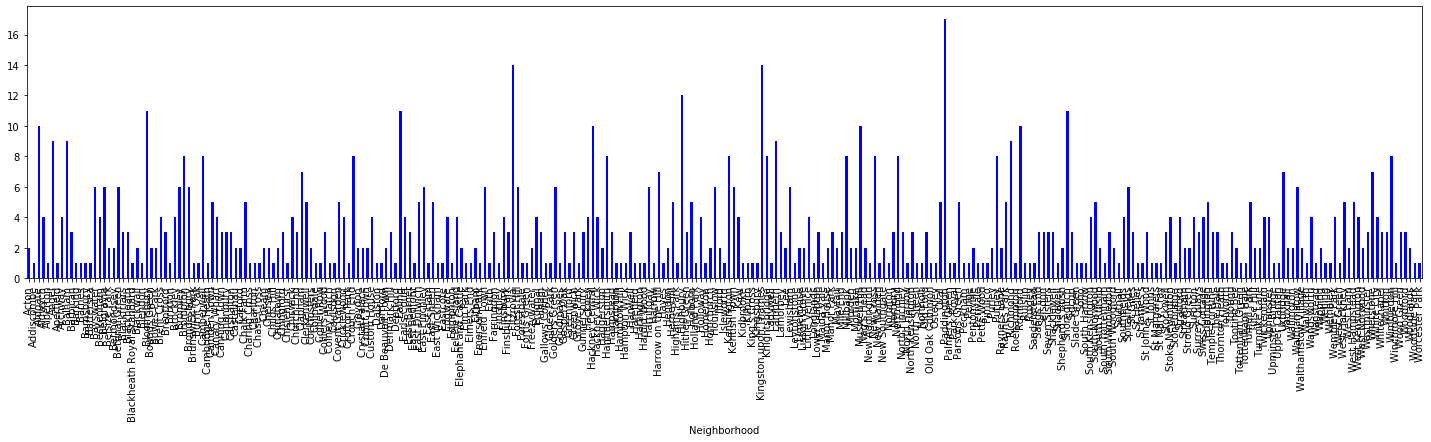

In [16]:
# check how many cafés per neighborhood

london_cafe_df.groupby('Neighborhood')['Venue'].count().plot.bar(figsize=(25,5), color="blue")
plt.title('Cafés per Neighborhood: London', fontsize = 16)
plt.xlabel('Neighborhood', fontsize = 12)
plt.ylabel('No. cafés',fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

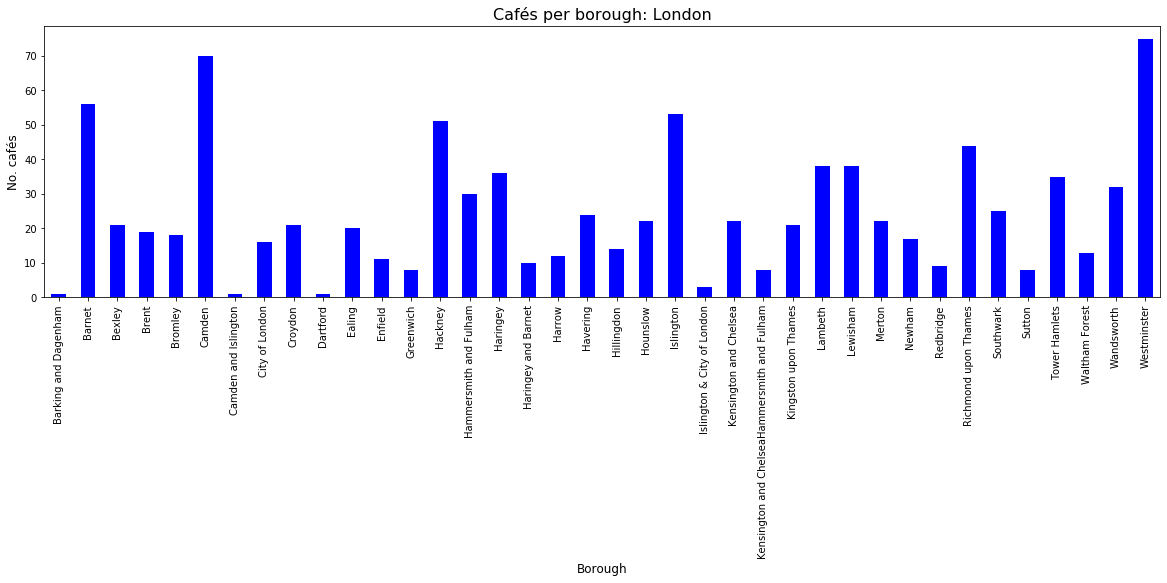

In [17]:
# check how many cafés per borough

london_cafe_df.groupby('Borough')['Venue'].count().plot.bar(figsize=(20,5), color="blue")
plt.title('Cafés per borough: London', fontsize = 16)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. cafés',fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

In [47]:
#london_cafe_df.drop(['Unnamed: 0'], axis=1, inplace = True)
london_cafe_df.head(5)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue_x,Venue Latitude,Venue Longitude,Venue Category,Venue_y
0,Ealing,Acton,51.508140,-0.273261,517d323fe4b0b4d24c007345,Costa Coffee,51.506879,-0.269368,Coffee Shop,2
1,Ealing,Acton,51.508140,-0.273261,4d971048a2c654815e9dce53,Frank's Cafe,51.508083,-0.270300,Café,2
2,Croydon,Addiscombe,51.379692,-0.074282,533fea17498e1f39b6eab646,The Tram Stop,51.380188,-0.073378,Café,1
3,City of London,Aldgate,51.514248,-0.075719,4f70a772e4b0f375fc669005,The Association,51.513733,-0.079132,Coffee Shop,10
4,City of London,Aldgate,51.514248,-0.075719,4cb1d779562d224b09ec2188,Fazenda,51.516169,-0.077414,Coffee Shop,10


In [18]:
london_cafe2_df = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'ID', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])

london_cafe2_df = london_cafe_df[500::]

print(london_cafe2_df.shape)
london_cafe2_df.head()

(425, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Venue Category
500,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,4b6be6b0f964a520f51b2ce3,Costa Coffee,51.411664,-0.304736,Coffee Shop
501,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,4b7be82df964a52026732fe3,Starbucks,51.410867,-0.301778,Coffee Shop
502,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,51af1a17498e9b28860483f5,Costa Coffee,51.411644,-0.304514,Coffee Shop
503,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,4ef077bdf9ab3edffbca122e,M&S Café Revive,51.410849,-0.303804,Café
504,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,4b9516a4f964a520948e34e3,Caffè Nero,51.409690,-0.304033,Coffee Shop


In [26]:
column=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips', 'Venue', 'Venue Latitude', 'Venue Longitude']
cafe_stats_london2=pd.DataFrame(columns=column)
count=1

for row in london_cafe2_df.values.tolist():
    Borough, Neighborhood, Neighborhood_Latitude, Neighborhood_Longitude, ID, Venue, Venue_Latitude, Venue_Longitude, Venue_Category=row
    try:
        venue_details = get_venue_details(ID)
        id,name,likes,rating,tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these cafés as they may have been recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(london_cafe2_df),')','processed')
    cafe_stats_london2 = cafe_stats_london2.append({'Borough': Borough,
                                            'Neighborhood': Neighborhood, 
                                            'ID': id,
                                            'Venue' : name,
                                            'Likes' : likes,
                                            'Rating' : rating,
                                            'Tips' : tips,
                                            'Venue Latitude' : Venue_Latitude,
                                            'Venue Longitude' : Venue_Longitude
                                                }, ignore_index=True)
    count+=1

print(cafe_stats_london2.shape)
cafe_stats_london2.head(20)

( 1 / 425 ) processed
( 2 / 425 ) processed
( 3 / 425 ) processed
( 4 / 425 ) processed
( 5 / 425 ) processed
( 6 / 425 ) processed
( 7 / 425 ) processed
( 8 / 425 ) processed
( 9 / 425 ) processed
( 10 / 425 ) processed
( 11 / 425 ) processed
( 12 / 425 ) processed
( 13 / 425 ) processed
No data available for id= 5217d90611d2eda63cd99981
( 14 / 425 ) processed
( 15 / 425 ) processed
( 16 / 425 ) processed
( 17 / 425 ) processed
( 18 / 425 ) processed
( 19 / 425 ) processed
( 20 / 425 ) processed
( 21 / 425 ) processed
( 22 / 425 ) processed
( 23 / 425 ) processed
( 24 / 425 ) processed
( 25 / 425 ) processed
( 26 / 425 ) processed
No data available for id= 4f8d6437e4b013d9a5231f1c
( 27 / 425 ) processed
No data available for id= 4b49cd87f964a520d97326e3
( 28 / 425 ) processed
No data available for id= 4e01ea57d22db37fb0298ae6
( 29 / 425 ) processed
( 30 / 425 ) processed
( 31 / 425 ) processed
( 32 / 425 ) processed
( 33 / 425 ) processed
( 34 / 425 ) processed
No data available for i

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Venue,Venue Latitude,Venue Longitude
0,Kingston upon Thames,Kingston upon Thames,4b6be6b0f964a520f51b2ce3,NaN,37,7.0,10,Costa Coffee,51.411664,-0.304736
1,Kingston upon Thames,Kingston upon Thames,4b7be82df964a52026732fe3,NaN,94,7.2,14,Starbucks,51.410867,-0.301778
2,Kingston upon Thames,Kingston upon Thames,51af1a17498e9b28860483f5,NaN,4,6.7,1,Costa Coffee,51.411644,-0.304514
3,Kingston upon Thames,Kingston upon Thames,4ef077bdf9ab3edffbca122e,NaN,1,6.5,1,M&S Café Revive,51.410849,-0.303804
4,Kingston upon Thames,Kingston upon Thames,4b9516a4f964a520948e34e3,NaN,17,6.4,10,Caffè Nero,51.409690,-0.304033
5,Kingston upon Thames,Kingston upon Thames,54c10f68498e7fe1b568e459,NaN,2,5.9,1,Costa Coffee,51.409649,-0.306561
6,Westminster,Knightsbridge,5641abb038fa7b01648ae33e,NaN,492,9.3,120,Carpo,51.498949,-0.165498
7,Westminster,Knightsbridge,5cc1aea3a5a315002cff98f6,NaN,11,8.3,5,39 Steps Coffee Haus,51.498929,-0.165391
8,Westminster,Knightsbridge,52d71ac611d2dae852a0be1f,NaN,1001,8.5,263,Chapati & Karak,51.498400,-0.165931
9,Westminster,Knightsbridge,5a19c873356b4976e646ed4b,NaN,158,8.8,36,The Coffee Bar,51.499171,-0.162803


In [33]:
cafe_stats_london1 = pd.read_csv('cafe_stats_london.csv')
cafe_stats_london1.drop(['Unnamed: 0'], axis=1, inplace=True)
cafe_stats_london1.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Venue,Venue Latitude,Venue Longitude
495,Kingston upon Thames,Kingston upon Thames,58524cbd7220e6111bc210cc,NaN,34,7.7,9,Department of Coffee and Social Affairs,51.410531,-0.306771
496,Kingston upon Thames,Kingston upon Thames,4c1cdefaeac020a1e62747c2,NaN,26,7.3,10,Patisserie Valerie,51.409163,-0.306346
497,Kingston upon Thames,Kingston upon Thames,57a9f135498ee9c9ae95f4f9,NaN,42,8.0,15,Beanberry,51.411793,-0.302921
498,Kingston upon Thames,Kingston upon Thames,4bb5d82df562ef3bf74b2f97,NaN,14,7.6,1,Caffè Nero,51.411927,-0.304642
499,Kingston upon Thames,Kingston upon Thames,4b1142cdf964a5206a7923e3,NaN,69,7.6,14,Starbucks,51.411635,-0.303843


In [34]:
# Remove rows with a Venue that is "0".
cafe_stats_london2.drop(cafe_stats_london2[cafe_stats_london2['ID']==0].index,axis=0, inplace=True)

final = [cafe_stats_london1, cafe_stats_london2]
cafe_stats_london = pd.concat(final)

print(cafe_stats_london1.shape)
print(cafe_stats_london2.shape)
print(cafe_stats_london.shape)
cafe_stats_london.head()

(500, 10)
(359, 10)
(859, 10)


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Venue,Venue Latitude,Venue Longitude
0,Ealing,Acton,517d323fe4b0b4d24c007345,NaN,14,6.4,3,Costa Coffee,51.506879,-0.269368
1,Ealing,Acton,0,NaN,0,0.0,0,0,51.508083,-0.270300
2,Croydon,Addiscombe,533fea17498e1f39b6eab646,NaN,12,7.9,2,The Tram Stop,51.380188,-0.073378
3,City of London,Aldgate,4f70a772e4b0f375fc669005,NaN,277,9.0,89,The Association,51.513733,-0.079132
4,City of London,Aldgate,4cb1d779562d224b09ec2188,NaN,32,8.1,18,Fazenda,51.516169,-0.077414


In [39]:
# Remove rows with a Venue that is "0".
cafe_stats_london.drop(cafe_stats_london[cafe_stats_london['ID']=="0"].index,axis=0, inplace=True)

print(cafe_stats_london.shape)
cafe_stats_london.head(20)

(744, 10)


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Venue,Venue Latitude,Venue Longitude
0,Ealing,Acton,517d323fe4b0b4d24c007345,NaN,14,6.4,3,Costa Coffee,51.506879,-0.269368
2,Croydon,Addiscombe,533fea17498e1f39b6eab646,NaN,12,7.9,2,The Tram Stop,51.380188,-0.073378
3,City of London,Aldgate,4f70a772e4b0f375fc669005,NaN,277,9.0,89,The Association,51.513733,-0.079132
4,City of London,Aldgate,4cb1d779562d224b09ec2188,NaN,32,8.1,18,Fazenda,51.516169,-0.077414
5,City of London,Aldgate,59f97d45acb00b6e13f7d430,NaN,12,7.7,2,Black Sheep Coffee,51.513990,-0.075459
6,City of London,Aldgate,58af36849435a903b9148728,NaN,8,7.4,2,Whitechapel Grind,51.514409,-0.072834
7,City of London,Aldgate,56bd9566498e17276fd1943c,NaN,23,7.8,7,Nude Espresso,51.516894,-0.075482
8,City of London,Aldgate,5548bf3e498e5a453a75bb45,NaN,40,7.5,11,Black Sheep Coffee,51.515066,-0.072126
9,City of London,Aldgate,56cf0e4c498e3a5a5e7326c3,NaN,18,8.0,1,Notes Coffee Roaster & Wine Bar,51.514643,-0.080671
10,City of London,Aldgate,520e158a11d25f11387631f8,NaN,10,6.9,5,Peter's Cafe,51.514076,-0.075482


In [40]:
# Save the information so far to a .csv file due to limited calls on FourSquare
cafe_stats_london.to_csv('cafe_stats_london_final.csv')
#cafe_stats_london = pd.read_csv('cafe_stats_london_final.csv')
#cafe_stats_london.drop(['Unnamed: 0'], axis=1, inplace=True)
#cafe_stats_london.head()

In [41]:
# converting the Likes and Tips to float
cafe_stats_london['Likes']=cafe_stats_london['Likes'].astype('float64')
cafe_stats_london['Tips']=cafe_stats_london['Tips'].astype('float64')
cafe_stats_london.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744 entries, 0 to 424
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Borough          744 non-null    object 
 1   Neighborhood     744 non-null    object 
 2   ID               744 non-null    object 
 3   Name             0 non-null      float64
 4   Likes            744 non-null    float64
 5   Rating           744 non-null    float64
 6   Tips             744 non-null    float64
 7   Venue            744 non-null    object 
 8   Venue Latitude   744 non-null    float64
 9   Venue Longitude  744 non-null    float64
dtypes: float64(6), object(4)
memory usage: 63.9+ KB


In [42]:
# get the average rating of cafés in each neighborhood
cafe_neighborhood=cafe_stats_london.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
cafe_neighborhood.columns=['Neighborhood','Average Rating']
cafe_neighborhood.sort_values(['Average Rating'],ascending=False).head(20)

,Neighborhood,Average Rating
142,Limehouse,9.100000
25,Brixton,9.100000
124,Homerton,9.000000
67,Deptford,8.900000
154,Nag's Head,8.850000
234,West Green,8.700000
22,Bowes Park,8.700000
14,Belsize Park,8.600000
63,Dalston,8.600000
170,Pentonville,8.600000


In [43]:
# get the average rating of cafés in each borough
cafe_borough=cafe_stats_london.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
cafe_borough.columns=['Borough','Average Rating']
cafe_borough.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Rating
6,Camden and Islington,8.500000
22,Islington & City of London,8.333333
23,Kensington and Chelsea,7.890909
34,Tower Hamlets,7.879310
13,Hackney,7.800000
7,City of London,7.743750
37,Westminster,7.555385
21,Islington,7.517391
5,Camden,7.455385
36,Wandsworth,7.341379


<br>We would like to open our café in a neighborhood where cafés have a good rating - for this project, we decided to focus on the neighborhood with rating equal to or greater than 8.<br>
We will visually map the neighborhoods with an average rating equal to or greater than 8. <br>

In [44]:
cafe_neighborhood=cafe_neighborhood[cafe_neighborhood['Average Rating']>=8.0]
cafe_neighborhood=pd.merge(cafe_neighborhood,london_df, on='Neighborhood')
cafe_neighborhood=cafe_neighborhood[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

# sorting the neighborhoods by average rating, in a descending way.
cafe_neighborhood.sort_values(by='Average Rating', ascending=False, inplace=True)

# add the column number of venues per neighborhood
c_df = london_cafe_df[["Neighborhood", "Venue"]].copy()
count_df = c_df.groupby('Neighborhood')['Venue'].count()
london_cafe_df = london_cafe_df.merge(count_df, on='Neighborhood', how='left')

print(cafe_neighborhood.shape)
cafe_neighborhood

(43, 5)


,Borough,Neighborhood,Latitude,Longitude,Average Rating
5,Lambeth,Brixton,51.456804,-0.116796,9.100000
28,Tower Hamlets,Limehouse,51.513307,-0.035149,9.100000
23,Hackney,Homerton,51.547079,-0.043121,9.000000
16,Lewisham,Deptford,51.475845,-0.021516,8.900000
31,Islington,Nag's Head,51.512979,-0.123620,8.850000
42,Haringey,West Green,51.586806,-0.089849,8.700000
4,Haringey,Bowes Park,51.607186,-0.120485,8.700000
33,Islington,Pentonville,51.531858,-0.108423,8.600000
15,Hackney,Dalston,51.543402,-0.067229,8.600000
11,Kensington and Chelsea,Chelsea,51.487542,-0.168220,8.600000


In [45]:
import folium
import seaborn as sns
from geopy.geocoders import Nominatim 

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

# create London map and display it
london_map = folium.Map(location=geo_location('London'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhoods
for lat, lng, in cafe_neighborhood[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='black',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.6
        )
    )
    
cafe_neighborhood['Label']=cafe_neighborhood['Neighborhood']+', '+cafe_neighborhood['Borough']+'('+cafe_neighborhood['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in cafe_neighborhood[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(london_map)        

    # add incidents to map
london_map.add_child(incidents)

In [48]:
# add the column number of venues per neighborhood
total = london_cafe_df.groupby(['Neighborhood'])['Venue_x'].count().reset_index(name="Number of Venue")

cafe_neighborhood = cafe_neighborhood.merge(total, on='Neighborhood', how='left')

print(cafe_neighborhood.shape)
cafe_neighborhood

(43, 7)


,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label,Number of Venue
0,Lambeth,Brixton,51.456804,-0.116796,9.100000,"Brixton, Lambeth(9.1)",1
1,Tower Hamlets,Limehouse,51.513307,-0.035149,9.100000,"Limehouse, Tower Hamlets(9.1)",2
2,Hackney,Homerton,51.547079,-0.043121,9.000000,"Homerton, Hackney(9.0)",1
3,Lewisham,Deptford,51.475845,-0.021516,8.900000,"Deptford, Lewisham(8.9)",1
4,Islington,Nag's Head,51.512979,-0.123620,8.850000,"Nag's Head, Islington(8.85)",2
5,Haringey,West Green,51.586806,-0.089849,8.700000,"West Green, Haringey(8.7)",1
6,Haringey,Bowes Park,51.607186,-0.120485,8.700000,"Bowes Park, Haringey(8.7)",2
7,Islington,Pentonville,51.531858,-0.108423,8.600000,"Pentonville, Islington(8.6)",2
8,Hackney,Dalston,51.543402,-0.067229,8.600000,"Dalston, Hackney(8.6)",1
9,Kensington and Chelsea,Chelsea,51.487542,-0.168220,8.600000,"Chelsea, Kensington and Chelsea(8.6)",2


In [50]:
#let's consider only the neighborhood with at least cafés - so data can be more accurate
cafe_neighborhood2 = cafe_neighborhood.loc[(cafe_neighborhood['Number of Venue'] >2)]
cafe_neighborhood2

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label,Number of Venue
16,Hackney,Hackney,51.543240,-0.049362,8.466667,"Hackney, Hackney(8.466666666666667)",4
19,Hackney,Shoreditch,51.526669,-0.079893,8.388889,"Shoreditch, Hackney(8.38888888888889)",11
20,Tower Hamlets,Spitalfields,51.519527,-0.075170,8.383333,"Spitalfields, Tower Hamlets(8.383333333333333)",6
21,Camden,Fitzrovia,51.518764,-0.141002,8.357143,"Fitzrovia, Camden(8.357142857142858)",14
22,Islington & City of London,Farringdon,51.520124,-0.104793,8.333333,"Farringdon, Islington & City of London(8.33333...",3
23,Hammersmith and Fulham,Fulham,51.474422,-0.206077,8.300000,"Fulham, Hammersmith and Fulham(8.3)",3
24,Kensington and Chelsea,North Kensington,51.519665,-0.210696,8.300000,"North Kensington, Kensington and Chelsea(8.299...",3
25,Tower Hamlets,Bethnal Green,51.530346,-0.056163,8.266667,"Bethnal Green, Tower Hamlets(8.266666666666667)",6
31,Westminster,Covent Garden,51.512874,-0.122544,8.180000,"Covent Garden, Westminster(8.18)",5
33,City of London,Barbican,51.520150,-0.098683,8.133333,"Barbican, City of London(8.133333333333335)",3


In [51]:
for lat, lng, in cafe_neighborhood2[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='black',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )
    
cafe_neighborhood2['Label']=cafe_neighborhood2['Neighborhood']+', '+cafe_neighborhood2['Borough']+'('+cafe_neighborhood2['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in cafe_neighborhood2[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(london_map)        

    # add incidents to map
london_map.add_child(incidents)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Conclusion: